## GRU model testing: detrended data
Next thing to try is detrended data input for our semi-optimized GRU. Only big difference here will be a rework of SMAPE scoring to take predicted changes, and convert them back into MBD values of SMAPE scoring.

In [1]:
import shelve
import numpy as np
import matplotlib.pyplot as plt

# Add notebook parent dir to path so we can import from functions/
import sys
sys.path.append('..')

# Import project config file
import config as conf

# Import notebooks specific helper functions
import functions.notebook_helper_functions.notebook15 as funcs
import functions.initialization_functions as init_funcs

# Instantiate paths and model parameters
paths = conf.DataFilePaths()
params = conf.GRU_model_parameters()

# Load data column index
index = shelve.open(paths.PARSED_DATA_COLUMN_INDEX)

# Fire up logger
logger = init_funcs.start_logger(
    logfile = f'{paths.LOG_DIR}/{params.log_file_name}',
    logstart_msg = 'Starting GRU hyperparameter optimization run'
)

In [2]:
# Load data with block size
input_file = f'{paths.PARSED_DATA_PATH}/{params.input_file_root_name}25.npy'
timepoints = np.load(input_file)

# Print some info.
print()
print(f'Input data shape: {timepoints.shape}')
print()

print('Input data column index:')

for column, num in index.items():
    print(f'{column}: {num}')


Input data shape: (15, 3135, 25, 6)

Input data column index:
cfips: 0
first_day_of_month: 1
microbusiness_density: 2
active: 3
microbusiness_density_change: 4
microbusiness_density_change_change: 5


The dimensions here are:

0. The timepoint block - the size of this axis depends on the width of the block used to scan the data - smaller blocks give more timepoints with num_timepoint_blocks = total_timepoints - block_size + 1. This is also the axis we need to do our training validation split on. First part becomes training, last part becomes validation.
1. The counties - each element here is a county, for the purposes of our first experiment we will treat each county as a batch.
2. The the timepoints in the timepoint block (~row in pandas dataframe).
3. The features (~column in pandas dataframe). To start with, we will work with one feature only - the microbusiness density.

First up - training/validation/testing split, followed by data standardization and then an axis swap to make the data batch major as is the convention for tensorflow:

In [4]:
datasets = funcs.training_validation_testing_split(
    index,
    timepoints,
    num_counties = params.num_counties,
    input_data_type = 'microbusiness_density_change_change',
    testing_timepoints = params.testing_timepoints,
    training_split_fraction = params.training_split_fraction,
    pad_validation_data = params.pad_validation_data,
    forecast_horizon = params.forecast_horizon
)

datasets, training_mean, training_deviation = funcs.standardize_datasets(datasets)
datasets = funcs.make_batch_major(datasets)

for data_type, data in datasets.items():
    print(f'{data_type} data shape: {data.shape}')

training data shape: (3135, 7, 25, 1)
validation data shape: (3135, 3, 25, 1)


Looks good! Let's build the model. Only additional thing to mention here is that for each time block in the counties, the first n - 5 datapoints are the time ordered input and the last five is the value we are trying to predict. With that in mind, let's go!

In [5]:
model, history = funcs.train_GRU(
    datasets,
    forecast_horizon = 5,
    epochs = 20,
    GRU_units = 64,
    learning_rate = 0.0001,
    save_tensorboard_log = params.save_tensorboard_log,
    tensorboard_log_dir = params.tensorboard_log_dir,
    tensorboard_histogram_freq = params.tensorboard_histogram_freq,
    save_model_checkpoints = params.save_model_checkpoints,
    model_checkpoint_dir = params.model_checkpoint_dir,
    model_checkpoint_threshold = params.model_checkpoint_threshold,
    model_checkpoint_variable = params.model_checkpoint_variable,
    early_stopping = params.early_stopping,
    early_stopping_monitor = params.early_stopping_monitor,
    early_stopping_min_delta = params.early_stopping_min_delta,
    early_stopping_patience = params.early_stopping_patience,
    verbose = 1
)

Epoch 1/20
3134/3135 [============================>.] - ETA: 0s - loss: 0.0203 - MAE: 0.0370
Epoch 1: val_loss improved from inf to 1.35164, saving model to /home/siderealyear/arkk/kaggle_microbusiness/logs/model_checkpoints/GRU_hyperparameter_optimization/detrended_data_test/GRU_units-64_learning_rate-0.0001/winner.ckpt
3135/3135 [==============================] - 34s 10ms/step - loss: 0.0203 - MAE: 0.0370 - val_loss: 1.3516 - val_MAE: 0.0570
Epoch 2/20
3134/3135 [============================>.] - ETA: 0s - loss: 0.0200 - MAE: 0.0366
Epoch 2: val_loss improved from 1.35164 to 1.34769, saving model to /home/siderealyear/arkk/kaggle_microbusiness/logs/model_checkpoints/GRU_hyperparameter_optimization/detrended_data_test/GRU_units-64_learning_rate-0.0001/winner.ckpt
3135/3135 [==============================] - 29s 9ms/step - loss: 0.0200 - MAE: 0.0366 - val_loss: 1.3477 - val_MAE: 0.0566
Epoch 3/20
3132/3135 [============================>.] - ETA: 0s - loss: 0.0198 - MAE: 0.0364
Epoch 3:

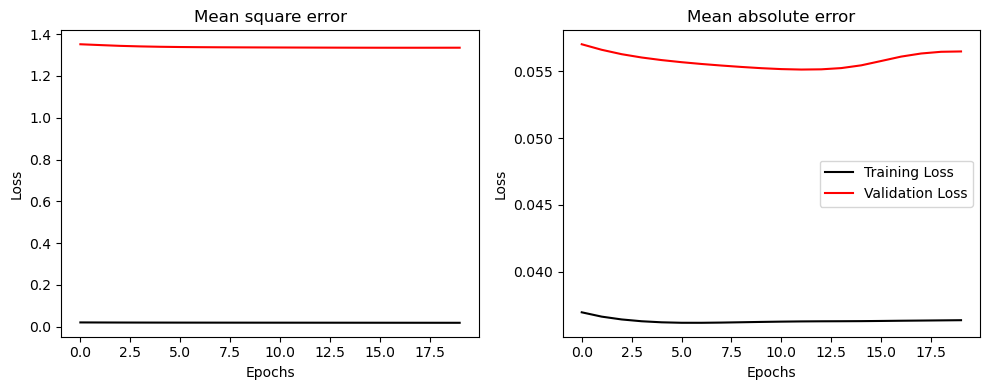

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot and label the training and validation MSE (loss)
ax[0].plot(list(range(len(history.history['loss']))), history.history['loss'], c='black', label='Training Loss')
ax[0].plot(list(range(len(history.history['val_loss']))), history.history['val_loss'], c='red', label='Validation Loss')
 
# Add in a title and axes labels
ax[0].set_title('Mean square error')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

# Plot and label the training and validation MAE
ax[1].plot(list(range(len(history.history['MAE']))), history.history['MAE'], c='black', label='Training Loss')
ax[1].plot(list(range(len(history.history['val_MAE']))), history.history['val_MAE'], c='red', label='Validation Loss')
 
# Add in a title and axes labels
ax[1].set_title('Mean absolute error')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
 
# Display the plot
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [7]:
predictions, targets = funcs.make_predictions(
    model, 
    datasets, 
    params.forecast_horizon, 
    training_mean, 
    training_deviation
)

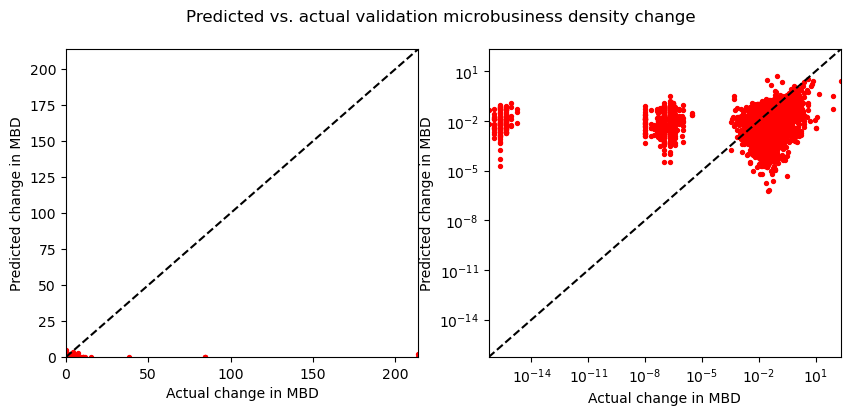

In [8]:
# Plot predicted vs actual MBD values for validation set

# Set common axis limits
data_pool = list(targets['validation'].flatten()) + list(predictions['GRU_validation'].flatten())
trimmed_data_pool = [i for i in data_pool if i > 0]

plot_max = max(trimmed_data_pool)
plot_min = min(trimmed_data_pool)

# Make plots
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot with linear axes
ax[0].scatter(targets['validation'].flatten(), predictions['GRU_validation'].flatten(), s=params.plot_point_size, c='red')

# Add y=x line
ax[0].axline((plot_min, plot_min), (plot_max, plot_max), color='black', linestyle='dashed')

# Set axis limits
ax[0].set_xlim([plot_min, plot_max])
ax[0].set_ylim([plot_min, plot_max])

# Add labels
ax[0].set_xlabel('Actual change in MBD')
ax[0].set_ylabel('Predicted change in MBD')

# Plot again with log10 axes
ax[1].scatter(targets['validation'].flatten(), predictions['GRU_validation'].flatten(), s=params.plot_point_size, c='red')

# Add y=x line
ax[1].axline((plot_min, plot_min), (plot_max, plot_max), color='black', linestyle='dashed')

# Set axis limits
ax[1].set_xlim([plot_min, plot_max])
ax[1].set_ylim([plot_min, plot_max])

# Add labels
ax[1].set_xlabel('Actual change in MBD')
ax[1].set_ylabel('Predicted change in MBD')

# Set log10 scales
ax[1].set_xscale('log')
ax[1].set_yscale('log')

# Add in main title
plt.suptitle('Predicted vs. actual validation microbusiness density change')
 
# Display the plot
plt.show()

In [9]:
# Split off the last three individual month's predictions
# this approximates the final private leaderboard scoring
index_3_validation_predictions = predictions['GRU_validation'][:,2]
index_4_validation_predictions = predictions['GRU_validation'][:,3]
index_5_validation_predictions = predictions['GRU_validation'][:,4]

index_3_validation_targets = targets['validation'][:,2]
index_4_validation_targets = targets['validation'][:,3]
index_5_validation_targets = targets['validation'][:,4]

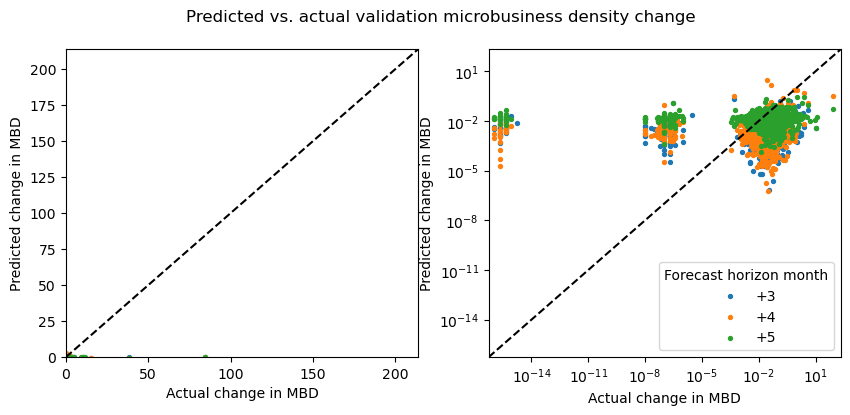

In [10]:
# Plot predicted vs actual MBD values for validation set by the forecast horizon index

# Set common axis limits
data_pool = list(targets['validation'].flatten()) + list(predictions['GRU_validation'].flatten())
trimmed_data_pool = [i for i in data_pool if i > 0]

plot_max = max(trimmed_data_pool)
plot_min = min(trimmed_data_pool)

# Make plots
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot with linear axes
ax[0].scatter(index_3_validation_targets, index_3_validation_predictions, s=params.plot_point_size, label='+3')
ax[0].scatter(index_4_validation_targets, index_4_validation_predictions, s=params.plot_point_size, label='+4')
ax[0].scatter(index_5_validation_targets, index_5_validation_predictions, s=params.plot_point_size, label='+5')

# Add y=x line
ax[0].axline((plot_min, plot_min), (plot_max, plot_max), color='black', linestyle='dashed')

# Set axis limits
ax[0].set_xlim([plot_min, plot_max])
ax[0].set_ylim([plot_min, plot_max])

# Add labels
ax[0].set_xlabel('Actual change in MBD')
ax[0].set_ylabel('Predicted change in MBD')

# Plot again with log10 axes
ax[1].scatter(index_3_validation_targets, index_3_validation_predictions, s=params.plot_point_size, label='+3')
ax[1].scatter(index_4_validation_targets, index_4_validation_predictions, s=params.plot_point_size, label='+4')
ax[1].scatter(index_5_validation_targets, index_5_validation_predictions, s=params.plot_point_size, label='+5')

# Add y=x line
ax[1].axline((plot_min, plot_min), (plot_max, plot_max), color='black', linestyle='dashed')

# Set axis limits
ax[1].set_xlim([plot_min, plot_max])
ax[1].set_ylim([plot_min, plot_max])

# Add labels
ax[1].set_xlabel('Actual change in MBD')
ax[1].set_ylabel('Predicted change in MBD')

# Set log10 scales
ax[1].set_xscale('log')
ax[1].set_yscale('log')

# Add in a title and axes labels
plt.suptitle('Predicted vs. actual validation microbusiness density change')
 
# Display the plot
plt.legend(title='Forecast horizon month', loc='best')
plt.show()

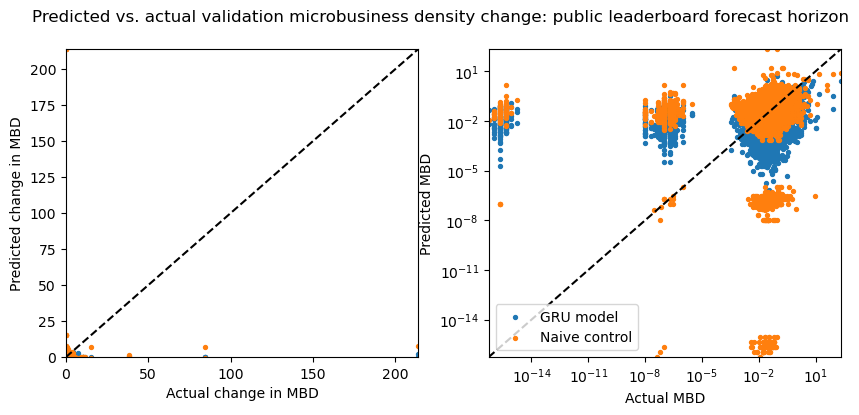

In [11]:
# Plot predicted vs actual MBD values for validation set by the forecast horizon index

# Set common axis limits
data_pool = list(targets['validation'][2:].flatten()) + list(predictions['GRU_validation'][2:].flatten()) + list(predictions['control_validation'][2:].flatten())
trimmed_data_pool = [i for i in data_pool if i > 0]

plot_max = max(trimmed_data_pool)
plot_min = min(trimmed_data_pool)

# Make plots
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot with linear axes
ax[0].scatter(targets['validation'][2:], predictions['GRU_validation'][2:], s=params.plot_point_size, label='GRU model')
ax[0].scatter(targets['validation'][2:], predictions['control_validation'][2:], s=params.plot_point_size, label='Naive control')

# Add y=x line
ax[0].axline((plot_min, plot_min), (plot_max, plot_max), color='black', linestyle='dashed')

# Set axis limits
ax[0].set_xlim([plot_min, plot_max])
ax[0].set_ylim([plot_min, plot_max])

# Add labels
ax[0].set_xlabel('Actual change in MBD')
ax[0].set_ylabel('Predicted change in MBD')

# Plot again with log10 axes
ax[1].scatter(targets['validation'][2:], predictions['GRU_validation'][2:], s=params.plot_point_size, label='GRU model')
ax[1].scatter(targets['validation'][2:], predictions['control_validation'][2:], s=params.plot_point_size, label='Naive control')

# Add y=x line
ax[1].axline((plot_min, plot_min), (plot_max, plot_max), color='black', linestyle='dashed')

# Set axis limits
ax[1].set_xlim([plot_min, plot_max])
ax[1].set_ylim([plot_min, plot_max])

# Add labels
ax[1].set_xlabel('Actual MBD')
ax[1].set_ylabel('Predicted MBD')

# Set log10 scales
ax[1].set_xscale('log')
ax[1].set_yscale('log')

# Add in a title and axes labels
plt.suptitle('Predicted vs. actual validation microbusiness density change: public leaderboard forecast horizon')
 
# Display the plot
plt.legend(loc='best')
plt.show()